In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp
from scipy.spatial import ConvexHull, QhullError
from scipy.ndimage import uniform_filter1d
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [ ]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    scores = pd.to_numeric(data['Previous Exam Score'], errors='coerce')
    scores = scores.dropna()
    return scores.values
file_path = "/content/student_exam_data.csv"
exam_scores = load_data(file_path)

In [ ]:
def convex_hull(scores, label="Data"):
    points = np.vstack((np.arange(len(scores)), scores)).T
    try:
        hull = ConvexHull(points)
        plt.figure(figsize=(10, 6))
        plt.plot(scores, color="blue", label=f"{label} Scores")
        plt.title(f"Convex Hull of {label} Data")
        plt.xlabel("Index")
        plt.ylabel(f"{label} Exam Score")
        plt.legend()
        plt.show()
    except QhullError:
        print(f"Error constructing convex hull for {label} data: The input is less than 2-dimensional or degenerate.")
        plt.figure(figsize=(10, 6))
        plt.plot(scores, color="blue", label=f"{label} Scores")
        plt.title(f"Convexity Check of {label} Data (No Hull)")
        plt.xlabel("Index")
        plt.ylabel(f"{label} Exam Score")
        plt.legend()
        plt.show()

In [ ]:
def check_convexity(scores, label="Scores"):
    scores = np.array(scores)
    second_diff = np.diff(scores, n=2)
    is_convex = np.all(second_diff >= 0)
    if is_convex:
        print(f"{label}: The function is convex.")
    else:
        print(f"{label}: The function is not convex.")
    return is_convex

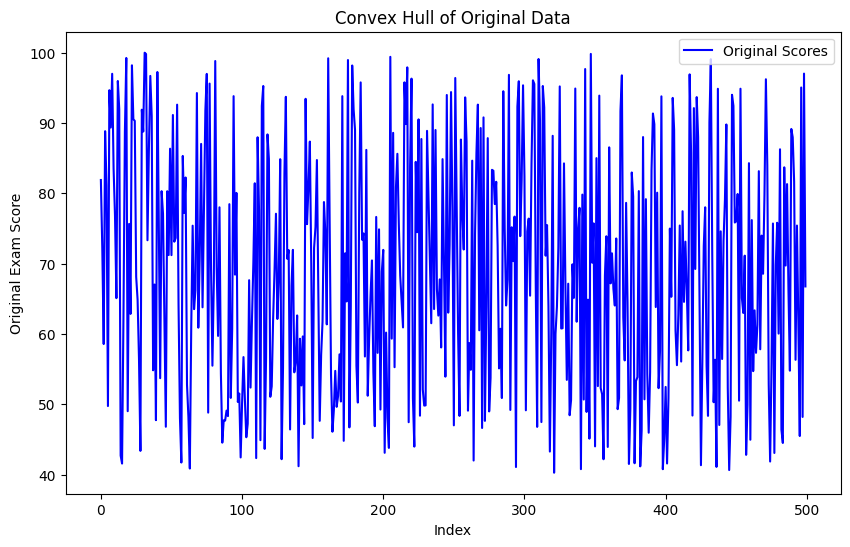

In [ ]:
convex_hull(exam_scores, label="Original")

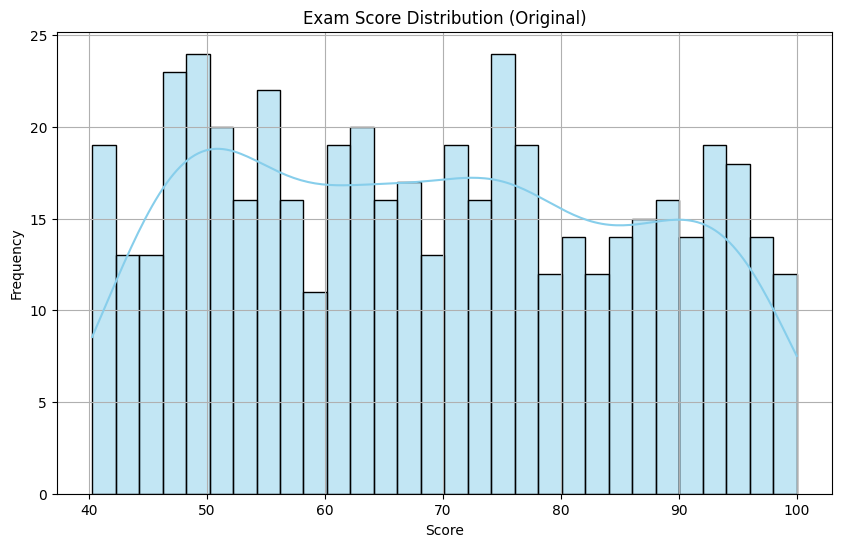

Original Mean Score: 68.92, Standard Deviation: 17.11


In [ ]:
mean_score = np.mean(exam_scores)
std_dev = np.std(exam_scores)
plt.figure(figsize=(10, 6))
sns.histplot(exam_scores, kde=True, bins=30, color='skyblue')
plt.title("Exam Score Distribution (Original)")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
print(f"Original Mean Score: {mean_score:.2f}, Standard Deviation: {std_dev:.2f}")

In [ ]:
check_convexity(exam_scores, label="Original")

Original: The function is not convex.


False

In [ ]:
def minimize_variance(scores, min_grade=5, max_grade=95):
    n = len(scores)
    adjusted_scores = cp.Variable(n)
    mean_score = cp.sum(adjusted_scores) / n
    variance = cp.sum_squares(adjusted_scores - mean_score) / n
    objective = cp.Minimize(variance)
    constraints = [
        adjusted_scores >= min_grade,
        adjusted_scores <= max_grade
    ]
    problem = cp.Problem(objective, constraints)
    problem.solve()
    is_convex = problem.is_dcp()
    print(f"Is the problem convex? {'Yes' if is_convex else 'No'}")
    return adjusted_scores.value
optimized_scores = minimize_variance(exam_scores)

Is the problem convex? Yes


Error constructing convex hull for Optimized data: The input is less than 2-dimensional or degenerate.


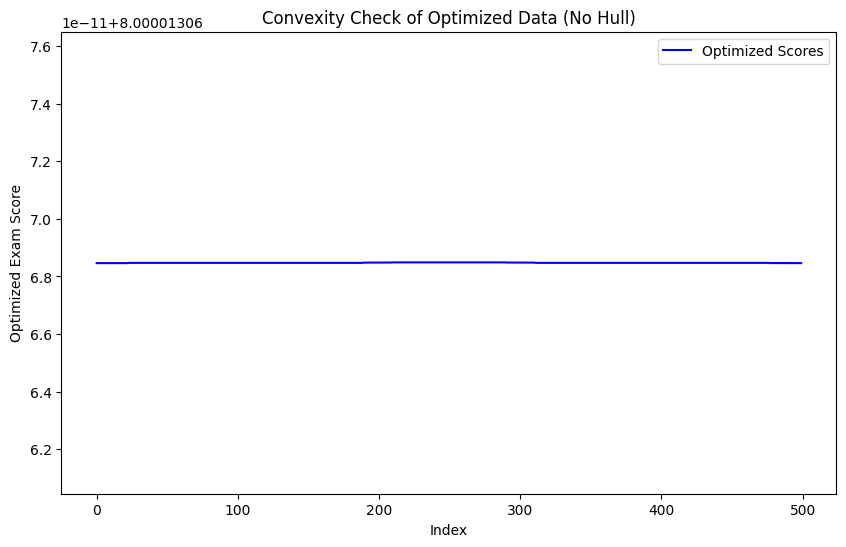

In [ ]:
convex_hull(optimized_scores, label="Optimized")

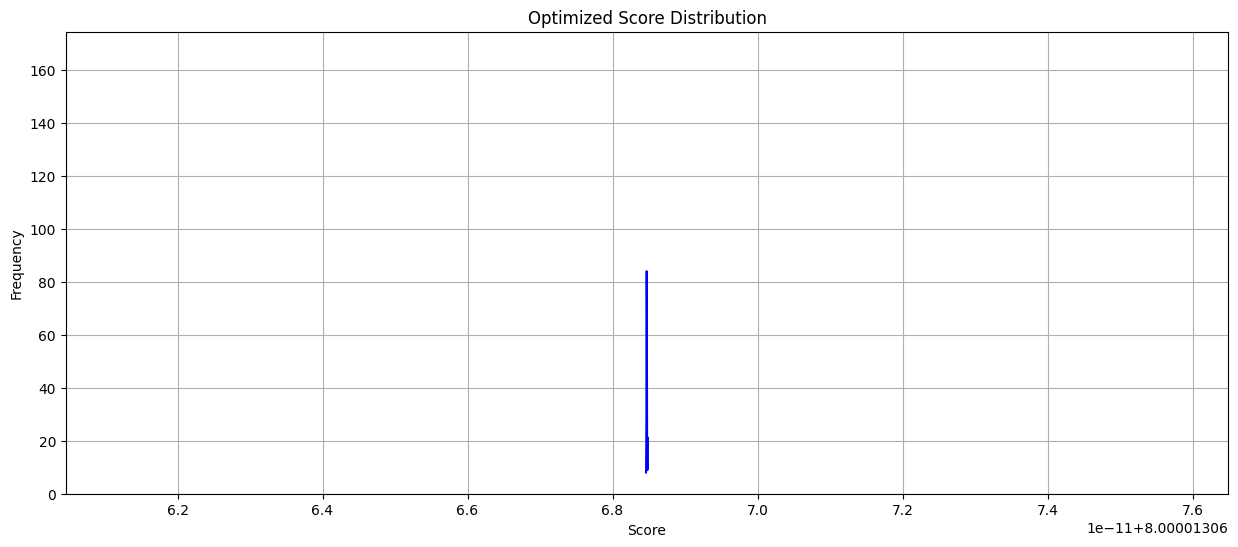

Optimized Mean Score: 8.00, Standard Deviation: 0.00


In [ ]:
optimized_mean = np.mean(optimized_scores)
optimized_std_dev = np.std(optimized_scores)
plt.figure(figsize=(15, 6))
sns.histplot(optimized_scores, kde=True, bins=30, color="blue")
plt.title("Optimized Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
print(f"Optimized Mean Score: {optimized_mean:.2f}, Standard Deviation: {optimized_std_dev:.2f}")

In [ ]:
def introduce_non_convexity(scores, noise_fraction=0.2, outlier_factor=20):
    noisy_scores = scores.copy()
    n = len(noisy_scores)
    num_modifications = int(n * noise_fraction)
    indices = np.random.choice(n, num_modifications, replace=False)
    outliers = np.random.uniform(low=np.min(scores) - outlier_factor,
                                  high=np.max(scores) + outlier_factor,
                                  size=num_modifications)
    noisy_scores[indices] = outliers
    return noisy_scores
noisy_scores = introduce_non_convexity(optimized_scores, noise_fraction=0.2, outlier_factor=20)

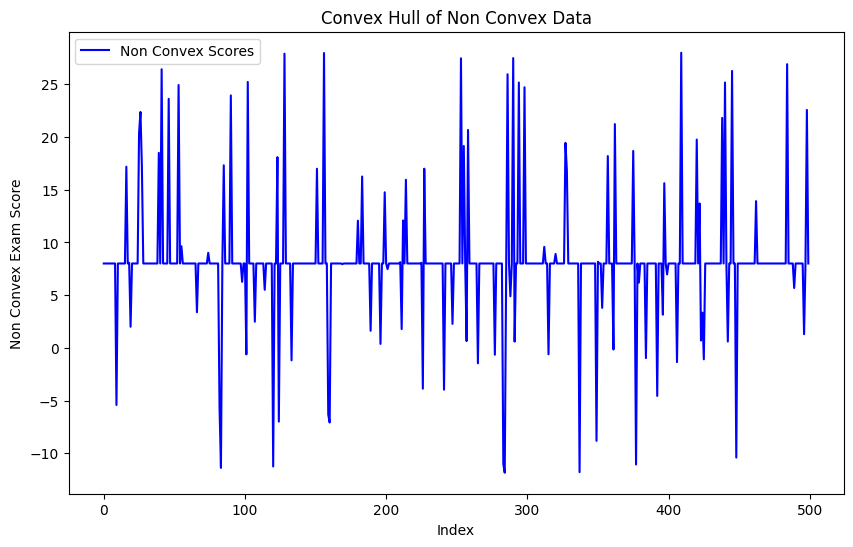

In [ ]:
convex_hull(noisy_scores, label="Non Convex")

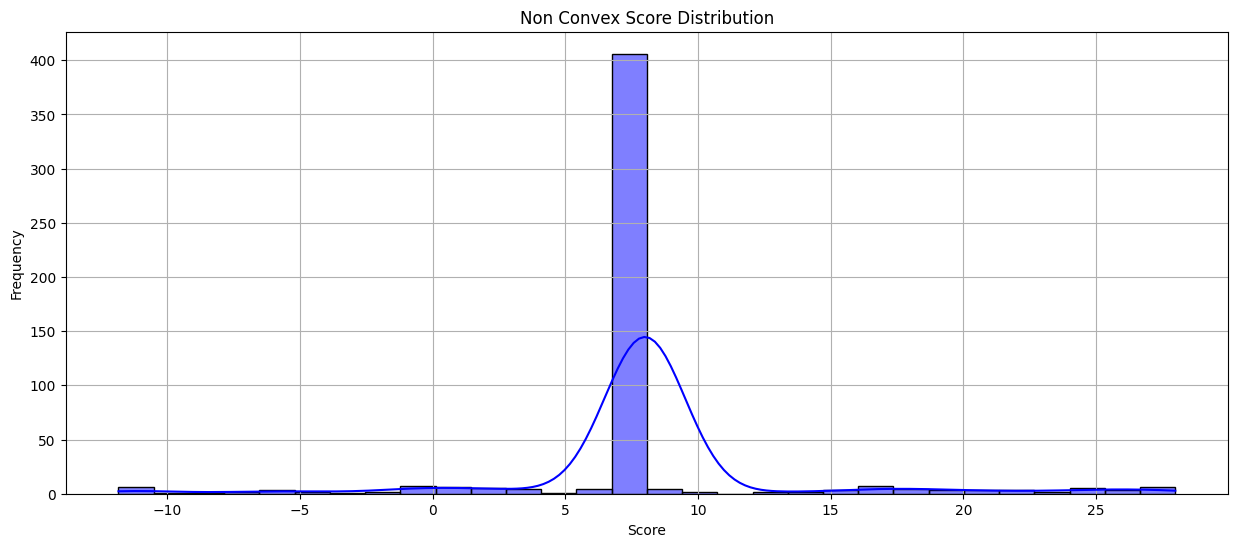

Optimized Mean Score: 8.22, Standard Deviation: 5.23


In [ ]:
noisy_mean = np.mean(noisy_scores)
noisy_std_dev = np.std(noisy_scores)
plt.figure(figsize=(15, 6))
sns.histplot(noisy_scores, kde=True, bins=30, color="blue")
plt.title("Non Convex Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
print(f"Optimized Mean Score: {noisy_mean:.2f}, Standard Deviation: {noisy_std_dev:.2f}")

In [ ]:
check_convexity(noisy_scores, label="Noisy")

Noisy: The function is not convex.


False

In [ ]:
def restore_convexity_ridge(scores, degree=2, alpha=1.0):
    scores = np.array(scores)
    restored_scores = scores.copy()
    x = np.arange(len(scores)).reshape(-1, 1)
    y = scores
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
    model.fit(x, y)
    restored_scores = model.predict(x)
    return restored_scores
restored_scores  = restore_convexity_ridge(noisy_scores)

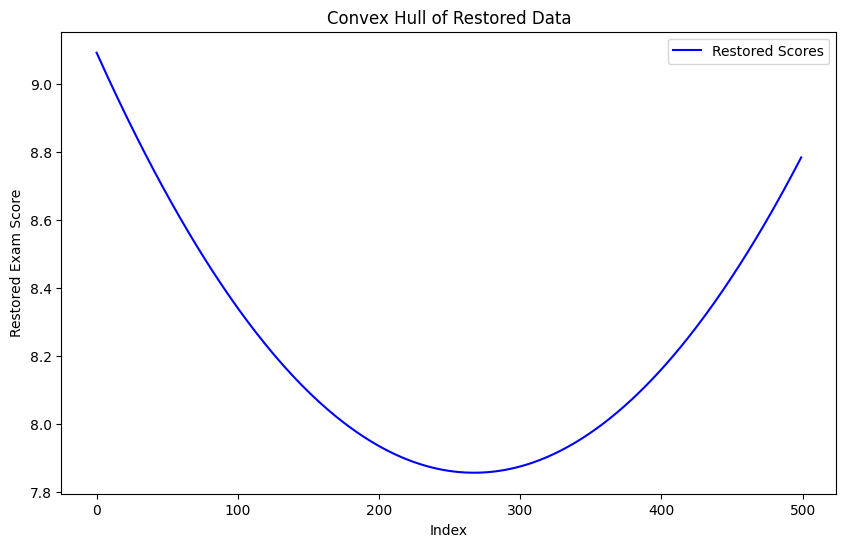

In [ ]:
convex_hull(restored_scores, label="Restored")

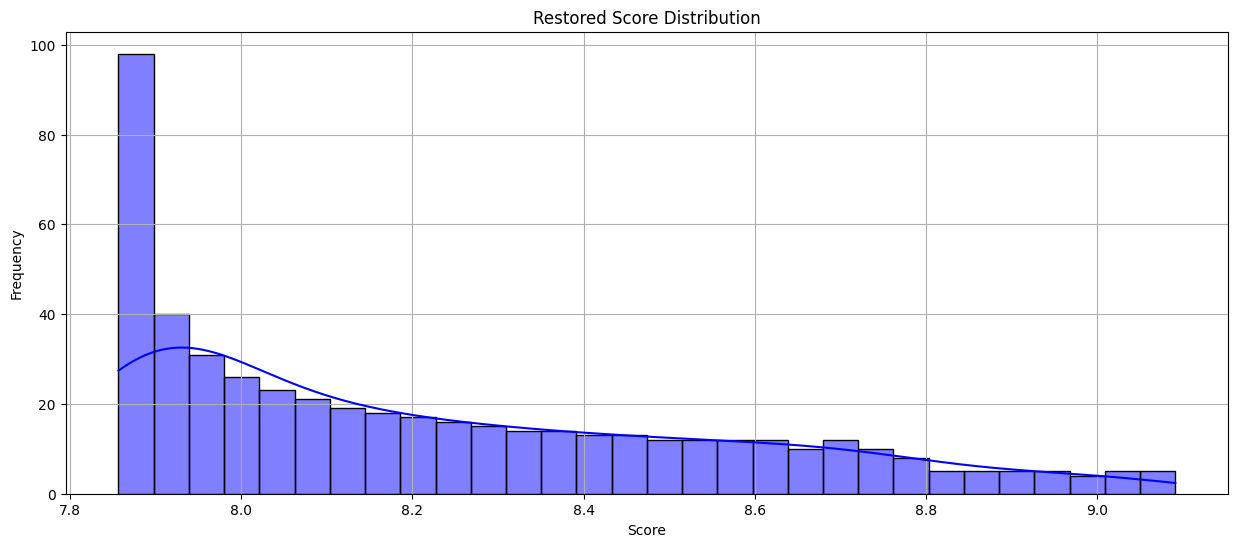

Optimized Mean Score: 8.22, Standard Deviation: 0.33


In [ ]:
restored_mean = np.mean(restored_scores)
restored_std_dev = np.std(restored_scores)
plt.figure(figsize=(15, 6))
sns.histplot(restored_scores, kde=True, bins=30, color="blue")
plt.title("Restored Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
print(f"Optimized Mean Score: {restored_mean:.2f}, Standard Deviation: {restored_std_dev:.2f}")

In [ ]:
check_convexity(restored_scores, label="Restored")

Restored: The function is convex.


True

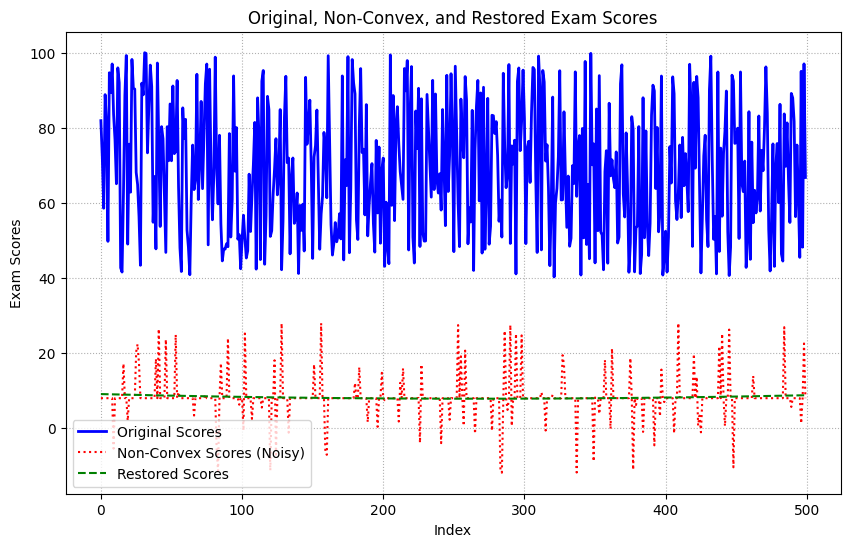

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(exam_scores, label="Original Scores", color="blue", linewidth=2)
plt.plot(noisy_scores, label="Non-Convex Scores (Noisy)", color="red", linestyle=":")
plt.plot(restored_scores, label="Restored Scores", color="green", linestyle="--")
plt.title("Original, Non-Convex, and Restored Exam Scores")
plt.xlabel("Index")
plt.ylabel("Exam Scores")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()